In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt 
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import date
from dateutil.relativedelta import relativedelta
from wordcloud import WordCloud, STOPWORDS 

In [2]:
# Read chatlog data
chatlog = pd.read_pickle('./data/chatlog.p') 

In [3]:
chatlog

,userId,full_name,message,role,_date,_time
0,2433413723406579,Watsana Kongngoen,สวัสดี,User,2019-11-01,15:23
1,2433413723406579,Watsana Kongngoen,"{'type': 'text', 'text': 'เงินติดล้อสวัสดีครับ'}",Admin,2019-11-01,15:23
2,2433413723406579,Watsana Kongngoen,"{'type': 'quick_reply', 'list_object': [{'text...",Admin,2019-11-01,15:23
3,2433413723406579,Watsana Kongngoen,สวัสดีครับ,User,2019-11-01,16:15
4,2433413723406579,Watsana Kongngoen,"{'type': 'text', 'text': 'เงินติดล้อสวัสดีครับ'}",Admin,2019-11-01,16:15
...,...,...,...,...,...,...
2298575,1379039449007314,None None,สาขา วังไผ่ (ชุมพร) ตรงข้ามบิ๊กซี สาขาชุมพร จ้า,User,2020-05-24,23:56
2298576,1379039449007314,None None,จริงใจพร้อมให้ความช่วยเหลือ รอสักครู่นะจ๊ะ,User,2020-05-24,23:57
2298577,1379039449007314,None None,เอกสารประกอบการยื่นเรื่อง\n1. เล่มทะเบียนรถตัว...,User,2020-05-24,23:58
2298578,1379039449007314,None None,รถปลอดภาระแล้วหรืออยู่ระหว่างผ่อนชำระคับ,User,2020-05-24,23:59


In [4]:
def check_keywords(txt):
    if "toyotavogo" in txt:
        return 1
    else:
        return 0

In [4]:
# Format time to match with the data
today = date.today()
td = today.strftime("%Y-%m-%d")

In [23]:
one_month = today + relativedelta(months=-1)
td_minus_one_month = one_month.strftime("%Y-%m-%d")

In [6]:
# Clean the chatlog to have only user conversation on specific date
def clean_chatlog(chatlog, start_date:str=td_minus_one_month, end_date:str=td):
    df = chatlog[['userId', 'message', 'role', '_date']] 
    df = df.loc[df.role=='User']
    return df[(df._date >= start_date) & (df._date <= end_date)]

In [7]:
df_new = clean_chatlog(chatlog, start_date='2019-11-01', end_date='2019-12-01')
df_new

,userId,message,role,_date
0,2433413723406579,สวัสดี,User,2019-11-01
3,2433413723406579,สวัสดีครับ,User,2019-11-01
6,2433413723406579,สวัสดีจ้า,User,2019-11-04
9,2433413723406579,ไม่ต้องยุ่งอ่ะ,User,2019-11-04
11,2433413723406579,ไม่ต้องมาคุย,User,2019-11-04
...,...,...,...,...
387454,2577671172269081,Toyota,User,2019-12-01
387456,2577671172269081,Yaris,User,2019-12-01
387458,2577671172269081,2019,User,2019-12-01
387465,2577671172269081,สุภาพร บุญเสริม,User,2019-12-01


In [8]:
df_new['check'] = df_new.message.apply(lambda x: check_keywords(x))

In [9]:
df_new[df_new['check'] == 1]

,userId,message,role,_date,check


In [8]:
# Utils
def get_th_tokens(text):
#     text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace(',', ' ')
    tokens = word_tokenize(text, engine="newmm", keep_whitespace=False)
    return tokens

In [9]:
# Clean undesired text
def clean_text_1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[.?]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[0-9]{1,10}', '', text)
    text = re.sub('นะ|น่ะ|น่า|น้า','',text)
    text = re.sub('คะ|ค่ะ|ค่า|คระ|คร่ะ|คร๊|ค๊|คร้า','',text)
    text = re.sub('ครับ|คับ|คั้บ|ค้าบ|คัฟ|คร้าบ|คาฟ|ค้าฟ|ฮะ|ฮับ|ฮ้าฟ','',text)
    text = re.sub('จ้า|จ้ะ|จ๊ะ','',text)
    text = re.sub('หน่อย|น่อย','',text)
    text = re.sub('สวัสดี|หวัดดี','',text)
    text = re.sub('ของ','',text)
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    text = re.sub(r'<.?>','', text)
    # ลบ hashtag
    text = re.sub(r'#','',text)
    # ลบ separator เช่น \n \t
    text = ' '.join(text.split())
    text = re.sub('สนใจ','',text)
    text = re.sub('อยากทราบว่า|อยากทราบ','',text)
    text = re.sub('รบกวนสอบถาม|ขอสอบถาม|สอบถาม','',text)
    text = re.sub('ปี','',text)
    text = re.sub('ขอบคุณ','',text)
    text = re.sub('ขอโทษ|ขอโทด','',text)
    text = re.sub('ขอ','',text)
    text = re.sub('ชั้น','',text)
    text = re.sub('เท่าไร|เท่าไหร่|เท่าหรั่ย|เท่าใด|เท่ารัย','',text)
    return text

In [10]:
def filter_words(text):
    text = text.replace('\n', ' ') 
    text = text.replace(',', ' ')
    stop_words = set(thai_stopwords()) 
    tokens = word_tokenize(text, engine="newmm", keep_whitespace=False) 
    filtered_text = [] 
    for w in tokens: 
        if w not in stop_words: 
            filtered_text.append(w) 
    return filtered_text

In [32]:
stop_words = set(thai_stopwords())

{'เพียงเพราะ', 'คราวนี้', 'หรือยัง', 'มิ', 'อย่างๆ', 'ที่นั้น', 'จัดให้', 'พวกฉัน', 'หากแม้นว่า', 'แท้จริง', 'สั้นๆ', 'พอตัว', 'กันดีไหม', 'นี่แหละ', 'ทั้งตัว', 'มุ่ง', 'เหตุ', 'เก็บ', 'สมัยนี้', 'ตั้งแต่', 'อนึ่ง', 'นํา', 'ราย', 'ใหญ่', 'ขณะเดียวกัน', 'กระผม', 'เพียงพอ', 'ขณะที่', 'จำเป็น', 'เหตุไร', 'นับแต่ที่', 'ส่วนด้อย', 'ช้าๆ', 'เกิน', 'ลง', 'ละ', 'ค่อยไปทาง', 'พอ', 'ที่ใด', 'หมดกัน', 'พอจะ', 'ยังคง', 'พา', 'เช่นกัน', 'เรียบ', 'คุณ', 'มั้ยนะ', 'เมื่อไร', 'ทุกๆ', 'อยู่', 'แต่เดิม', 'แค่ไหน', 'จัดทำ', 'มั้ยนั่น', 'สิ่งใด', 'ก็ได้', 'เฉย', 'เปิดเผย', 'เริ่ม', 'เล็กน้อย', 'คล้าย', 'อื่นๆ', 'ว่า', 'ยก', 'ที่สุด', 'เสียนั่น', 'ทำๆ', 'เพียงไหน', 'อันเนื่องมาจาก', 'ไง', 'ยิ่งใหญ่', 'การ', 'ภายหลัง', 'ใช่ไหม', 'ดั่ง', 'ยืนยาว', 'ทีละ', 'ทำให้', 'ยิ่งขึ้น', 'ข้างบน', 'ในเมื่อ', 'ยังงั้น', 'ช้านาน', 'อันที่จริง', 'คราวหลัง', 'ก็คือ', 'ทุกสิ่ง', 'ที่ละ', 'ที่แท้', 'อย่างหนึ่ง', 'เป็นอัน', 'เฉพาะ', 'วันนั้น', 'แต่ละ', 'หากแม้น', 'ภายภาค', 'ก่อนๆ', 'ตลอดไป', 'ก็ตาม', 'เห็นจะ', 'ณ', 'รือว่า', '

In [11]:
def remove_digits(text):
    output = re.sub(r'\d+', '', text)
    return output

In [12]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               u"\u200B"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [13]:
# Combine
def clean_text_full(df):
    df = df.groupby(['userId'])['message'].apply(','.join).reset_index()
    df['message'] = df['message'].apply(lambda x: clean_text_1(x))
    df['message'] = df['message'].apply(lambda x: remove_emoji(x))
    df['message'] = df['message'].apply(lambda x: remove_digits(x))
    df['message'] = df['message'].apply(lambda x: filter_words(x))
    df['message'] = df['message'].apply(lambda x: " ".join(x))
    return df

In [14]:
df_new_clean = clean_text_full(df_new)
df_new_clean

,userId,message
0,1009664972467205,ผ่อน ประกัน รถยนต์ ทำ honda ซิตี้ สมหมาย สุข พ...
1,1017090645081275,ข้อมูล เกี๋ยว บัตร เงิน ติด ล้อ ไหม พนักงาน โท...
2,1018334994957018,รถ กู้เงิน เค ร ดิส
3,1026835240773632,ตอนนี้ ลูกค้า ผ่อน งวด รี กู้
4,1032018316927422,มอไซค์ รี แนน ไหม
...,...,...
17523,979847622130129,จำนวน เงิน บาท สัญญา ต่อสัญญา หรอ ต่อสัญญา
17524,983670131756800,ค้าง งวด ยึด รถ เรย หรอ ค้ะ เห ที่มา ยึด รถ
17525,U6ef86f78e2256591a797b1085853317f,kfc ฉลอง ครบรอบ ในประเทศ ไทย แจก อาหาร ทาน ฟรี...
17526,Ufe1c28d4b7399dce582e6f23c91db3a6,ผม รายละเอียด อัตราดอกเบี้ย รถ มอไซค์


In [51]:
df_new['check'] = df_new.message.apply(lambda x: check_keywords(x))

In [52]:
df_new[df_new['check'] == 1]

,userId,message,role,_date,check


In [15]:
# find top 20 keywords that has the highest TF-IDF average score
def top_20_keywords(df):
    vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(3,3), min_df=2) 
    vectorizer.fit(df['message']) 
    feat_clean = vectorizer.transform(df['message']) 
    feat_clean_array = feat_clean.toarray() 
    avg_tfidf = feat_clean_array.sum(axis=0) / np.count_nonzero(feat_clean_array,axis=0) 
    result_clean = pd.DataFrame() 
    result_clean['word'] = vectorizer.get_feature_names() 
    result_clean['avg_tfidf'] = avg_tfidf 
    result_clean['word'] = result_clean['word'].apply(lambda x: x.replace(" ", ""))
    return result_clean.sort_values('avg_tfidf', ascending=False).head(20) 

In [16]:
def top_20_keywords_new(df):
    vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(3,3), min_df=2) 
    vectorizer.fit(df['message']) 
    feat_clean = vectorizer.transform(df['message']) 
    feat_clean_array = feat_clean.toarray() 
    avg_tfidf = feat_clean_array.sum(axis=0) / len(df['userId']) 
    result_clean = pd.DataFrame() 
    result_clean['word'] = vectorizer.get_feature_names() 
    result_clean['avg_tfidf'] = avg_tfidf 
    result_clean['word'] = result_clean['word'].apply(lambda x: x.replace(" ", ""))
    return result_clean.sort_values('avg_tfidf', ascending=False).head(20) 

In [17]:
df_new_normal = top_20_keywords(df_new_clean)
df_new_normal 

,word,avg_tfidf
3681,มิตรซูไทร,1.0
6645,แบตัวเตี้ย,1.0
4135,รถรุ่นไห,1.0
4151,รถอยุ่ไหม,1.0
1282,ซื้อประกันเปลี่ยนคน,1.0
5568,อยสกทราบ,1.0
1298,ซื้อรถยนต์มือสอง,1.0
5537,อยาทราบ,1.0
4177,รถเก่าไหม,1.0
7051,ไฟปนน,1.0


In [18]:
df_new_new = top_20_keywords_new(df_new_clean)
df_new_new 

,word,avg_tfidf
5843,เงินติดล้อ,0.014783
4727,รีไฟแนน,0.006098
4035,รถมอไซ,0.004347
6486,เวลาทำการกี่โมง,0.004150
2274,บัตรกดเงินสด,0.003141
1951,ทำประกันรถ,0.003068
1613,ติดล้อผ่อน,0.002487
5716,อีซูซุดีแม็กซ์,0.002462
5715,อีซูซุดีแม็ก,0.002381
3869,รถกะบะ,0.002367


In [25]:
df_new_new.to_excel('./excel/wc_freq.xlsx')

In [30]:
doc = "In the-state-of-art of the NLP field, Embedding is the \
success way to resolve text related problem and outperform \
Bag of Words ( BoW ). Indeed, BoW introduced limitations \
large feature dimension, sparse representation etc."
count_vec = CountVectorizer()
count_occurs = count_vec.fit_transform([doc])
count_occur_df = pd.DataFrame(
    (count, word) for word, count in
     zip(count_occurs.toarray().tolist()[0], 
    count_vec.get_feature_names()))
count_occur_df.columns = ['Word', 'Count']
count_occur_df.sort_values('Count', ascending=False, inplace=True)
count_occur_df.head()

,Word,Count
16,of,3
26,the,3
3,bow,2
0,and,1
28,way,1


In [37]:
corpus = df_new_clean['message']

0                                              วีออส ใรคั
1                                   ปผม วีโก้ แชมป์ ประตู
2                                                  ออ นิว
3       กรณี จำนำ เล่ม ทะเบียนรถยนต์ เปน ผู้ครอบครอง ก...
4                                                        
                              ...                        
2139                      isuzudmax sx สุรินทร์ ตรีทศ กุล
2140                                   มอ ไซ ผ่อน กู้ ไหม
2141                                         อีซูซุ d max
2142                ผม รายละเอียด อัตราดอกเบี้ย รถ มอไซค์
2143    รายละเอียด ประกัน รถยนต์ ข้อมูล ประกัน เริ่มต้...
Name: message, Length: 2144, dtype: object

In [50]:
count_vectorizer = CountVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(3,3), min_df=2)

In [51]:
count_vectorizer.fit(corpus)

CountVectorizer(min_df=2, ngram_range=(3, 3), token_pattern=None,
                tokenizer=<function get_th_tokens at 0x1c9805560>)

In [52]:
feat_count = count_vectorizer.transform(corpus)

In [53]:
feat_count_array = feat_count.toarray()

In [54]:
count_occurs_df = pd.DataFrame()

In [56]:
count_occur_df['word'] = count_vectorizer.get_feature_names()
count_occur_df['occurences'] = feat_count_array.sum(axis=0)

ValueError: Length of values does not match length of index

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
def count_words_use(df):
    count_vec = CountVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(3,3), min_df=2)
    count_occurs = count_vec.fit_transform(df['message'])
    count_occur_df = pd.DataFrame((count, word) for word, count in zip(count_occurs.toarray().tolist()[0], count_vec.get_feature_names()))
    count_occur_df.columns = ['Word', 'Count']
    return count_occur_df.sort_values('Count', ascending=False, inplace=True)

In [35]:
df_new_count = count_words_use(df_new_clean)
print(df_new_count)

None


In [19]:
def gen_text_for_wordcloud(df):
    words = df['word']
    words_to_array = words.tolist()
    return (" ".join(words_to_array))

In [20]:
text = gen_text_for_wordcloud(df_new_new)
print(text)

เงินติดล้อ รีไฟแนน รถมอไซ เวลาทำการกี่โมง บัตรกดเงินสด ทำประกันรถ ติดล้อผ่อน อีซูซุดีแม็กซ์ อีซูซุดีแม็ก รถกะบะ รถผ่อนกู้ อัลเมร่า รถมอเตอร์ไซ ทำประกันรถยนต์ นิสสันนาวาร่า มอไซร์ ประกันรถยน ติดล้อสาขา โตโยต้ารีโว่ ดอกง้อบัตรเครดิต


In [21]:
def gen_word_cloud(text):
    path = './font/THSarabunNew.ttf'
    wordcloud = WordCloud(font_path=path, width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10, colormap='coolwarm',regexp = r"[ก-๙a-zA-Z']+", random_state=1).generate(text) 
    # Plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.savefig('./WordCloud/keyword_{}.png'.format(td))
    

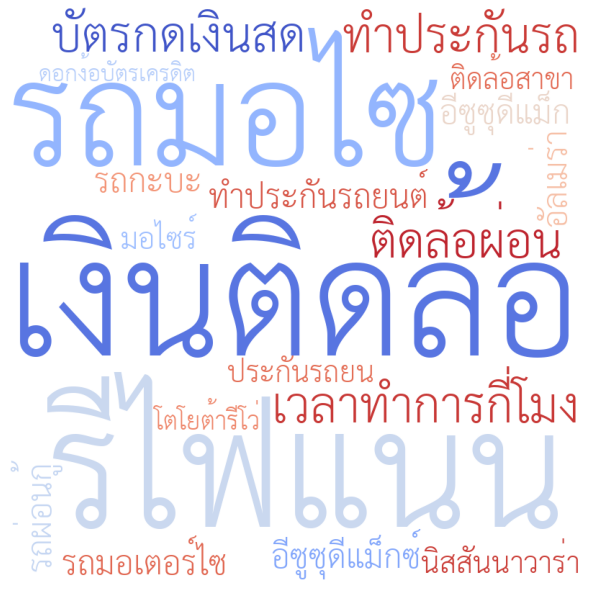

In [22]:
gen_word_cloud(text)

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
# list of text documents
text = ["The quick brown fox jumped over the lazy dog."]
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

{'the': 7, 'quick': 6, 'brown': 0, 'fox': 2, 'jumped': 3, 'over': 5, 'lazy': 4, 'dog': 1}
(1, 8)
<class 'scipy.sparse.csr.csr_matrix'>
[[1 1 1 1 1 1 1 2]]


In [20]:
submit_to_agent = pd.read_pickle('./data/submit_to_agent.p') 

In [21]:
df_sa = submit_to_agent.loc[submit_to_agent.reason=='not_response'].reset_index()

In [22]:
df_sa_new = df_sa.groupby(['userId'])['message'].apply(','.join).reset_index()

In [24]:
df_sa_new = clean_text_full(df_sa_new)